# Import the Data

In [1]:
!pip install scikit-image

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import pandas as pd 
from PIL import Image 
from skimage.transform import resize
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split

In [3]:
# Load the images and some metadata  
img_dir = 'data/'
img_w, img_h, img_ch = 224, 224, 3
filenames = os.listdir(img_dir) # read in the names of the image files 
filenames = [x.split('.')[0] for x in filenames] # remove the .jpg extensions for joining later 
img_files_df = pd.DataFrame(filenames, columns = ['Individual Patch']) # create a pandas dataframe 
img_files_df.head() # print the first few values to see if they look right 

,Individual Patch
0,020-3_10
1,019-1948-5_6
2,013-1988-C2_6
3,020-3_4
4,013-1988-C1_10


In [4]:
# Load the labels 
labels_dir = 'labels_new_new.csv'
labels_df = pd.read_csv(labels_dir, usecols=['Individual Patch', 'Binary Outcome'])
labels_df.head() # print the first few to see if they look right 

,Individual Patch,Binary Outcome
0,001-2002-1_1,0
1,001-2002-1_2,0
2,001-2002-1_3,0
3,001-2002-1_4,0
4,001-2002-1_5,0


# Pre Process the Data

In [5]:
# let's make sure each data point has both a label and an image by taking the intersection of these data frames 
full_data_points = img_files_df.merge(labels_df, on='Individual Patch')

# keep track of the total number of full data points 
num_imgs, _ = full_data_points.shape

In [6]:
# Iterate over all the images in the directory and place them in a numpy array 
# with their corresponding labels 
imgs = np.zeros((img_w, img_h, img_ch, num_imgs))
labels = np.zeros(num_imgs)
for i, img_file in enumerate(full_data_points['Individual Patch'].values): 
    
    # display progress
    if i % 100 == 0:
        print(i, 'out of', num_imgs, 'images processed')
        
    # read in the image     
    img = np.asarray(Image.open(img_dir + img_file + '.jpg'))
    
    # run pre-processing 
    imgs[:,:,:,i] = resize(img, (img_w, img_h, img_ch)) 
    
    labels[i] = labels_df['Binary Outcome'].iloc[i] 

0 out of 904 images processed
100 out of 904 images processed
200 out of 904 images processed
300 out of 904 images processed
400 out of 904 images processed
500 out of 904 images processed
600 out of 904 images processed
700 out of 904 images processed
800 out of 904 images processed
900 out of 904 images processed


# Explore the Data

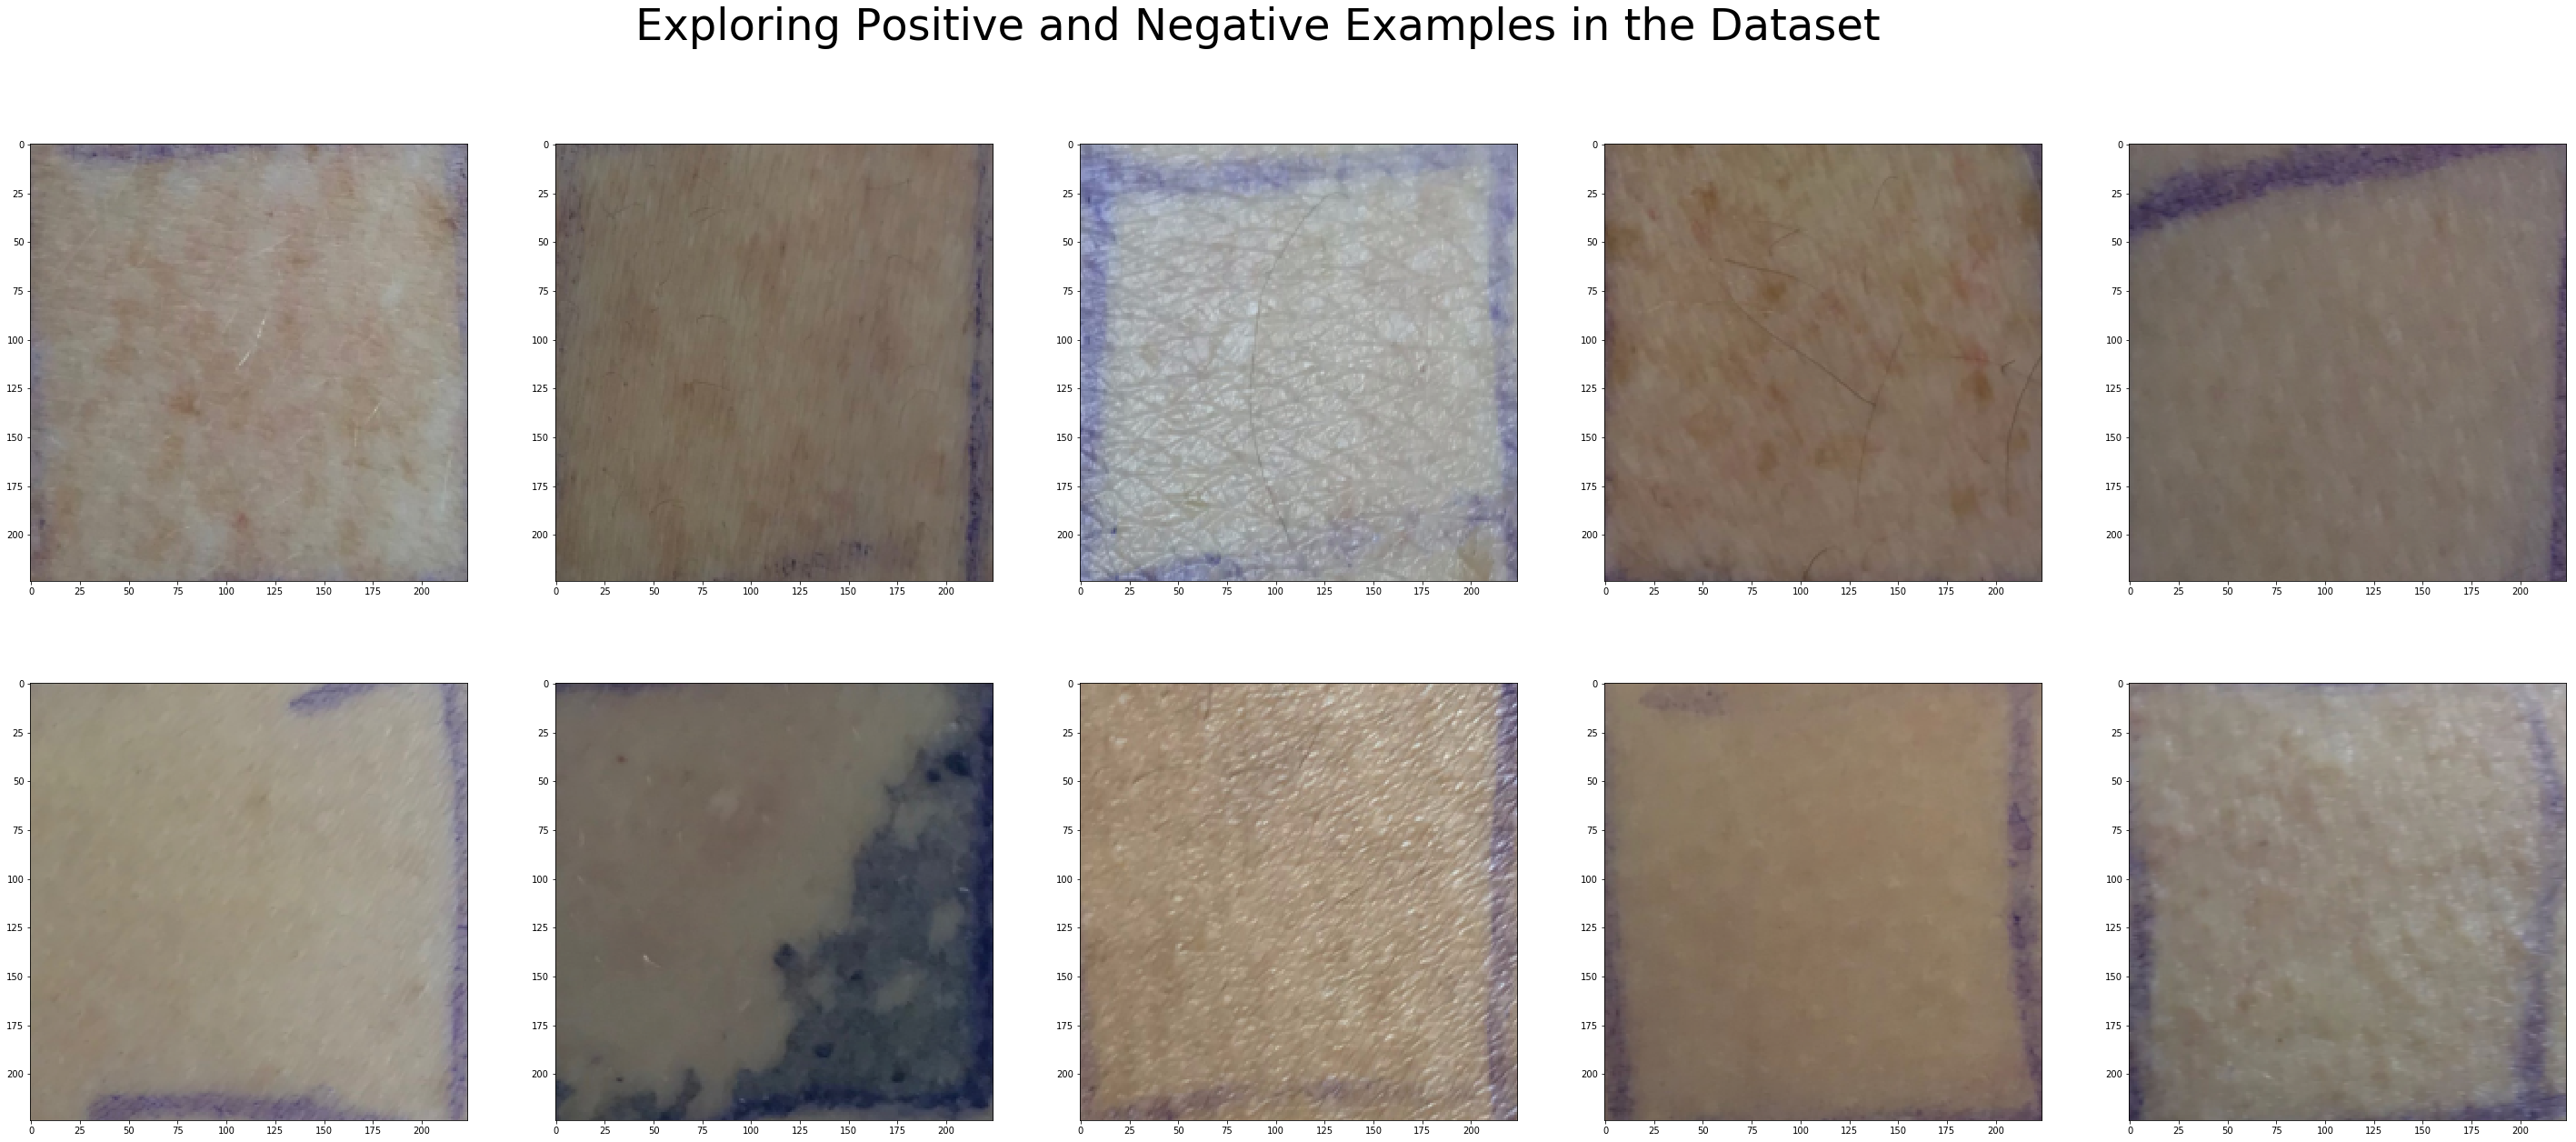

In [7]:
# Let's look at some positive and negative examples 

num_examples = 5
num_classes = 2

negative_indices = np.where(labels == 0)[0]
positive_indices = np.where(labels == 1)[0]

# randomly pick a subset from all of the examples 
negative_example_indices = np.random.choice(negative_indices, num_examples, replace=False)
positive_example_indices = np.random.choice(positive_indices, num_examples, replace=False)

plt.figure(figsize=(50, 20))
plt.suptitle('Exploring Positive and Negative Examples in the Dataset', fontsize=48)

# top row is negative examples 
for i, idx in enumerate(negative_example_indices): 
    plt.subplot(num_classes, num_examples, i+1)    
    plt.imshow(imgs[:,:,:,idx])

# bottom row is positive examples 
for i, idx in enumerate(positive_example_indices): 
    plt.subplot(num_classes, num_examples, i+num_examples+1)    
    plt.imshow(imgs[:,:,:,idx])

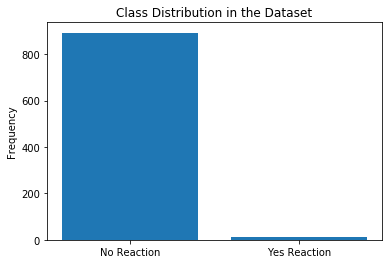

There are 892 negative examples and 12 positive examples in the data set


In [8]:
# Let's look at the distribution of classes present in the data set 

num_positive = len(positive_indices)
num_negative = len(negative_indices)

classes = ['No Reaction', 'Yes Reaction']
y_pos = np.arange(len(classes))
performance = [num_negative, num_positive]

plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, classes)
plt.ylabel('Frequency')
plt.title('Class Distribution in the Dataset')

plt.show()

print('There are', int(num_negative), 'negative examples and', int(num_positive), 'positive examples in the data set' )

Because of the huge class imbalance, we are going to approach this as an anolamy detection task 

# Run Data Augmentations

In [9]:
# Perform data augmentations to increase the size of the dataset 
r, c, ch, num_imgs = imgs.shape

flip_ud = np.zeros((r, c, ch, num_imgs))
flip_lr = np.zeros((r, c, ch, num_imgs))
rot90 = np.zeros((r, c, ch, num_imgs))
rot180 = np.zeros((r, c, ch, num_imgs))
rot270 = np.zeros((r, c, ch, num_imgs))

for i in range(num_imgs):
    
    if i % 100 == 0: # display progress 
        print(i, 'out of', num_imgs, 'images processed')
    original_img = imgs[:,:,:,i] 
    flip_ud[:,:,:,i] = np.flip(original_img, 0) # flip the image up-down
    flip_lr[:,:,:,i] = np.flip(original_img, 1) # flip the image left-right
    rot90[:,:,:,i] = np.rot90(original_img, 1) # rotate the image 90 degrees 
    rot180[:,:,:,i] = np.rot90(original_img, 2) # rotate the image 180 degrees 
    rot270[:,:,:,i] = np.rot90(original_img, 3) # rotate the image 270 degrees 
    
# Put them all together in one matrix 
aug_imgs = np.concatenate((imgs, flip_ud, flip_lr, rot90, rot180, rot270), axis=3)
aug_labels = np.tile(labels, 6) 

# Verify the shape of the resulting matrix 
print(aug_imgs.shape)
print(aug_labels.shape)

0 out of 904 images processed
100 out of 904 images processed
200 out of 904 images processed
300 out of 904 images processed
400 out of 904 images processed
500 out of 904 images processed
600 out of 904 images processed
700 out of 904 images processed
800 out of 904 images processed
900 out of 904 images processed
(224, 224, 3, 5424)
(5424,)


In [10]:
# save images and labels arrays so we don't have to recompute each time
# np.save('imgs_np_array.npy', aug_imgs)
# np.save('labels_np_array.npy', aug_labels)

# load images and labels arrays 
# aug_imgs = np.load('imgs_np_array.npy')
# aug_labels = np.load('labels_np_array.npy') 

# Split the data into training, validation, and test sets

### We only need to train the autoencoder on negative samples
Let's use 70% of the negative examples to train the model, 10% to find the threshold, and 20% to test on 

In [11]:
negative_indices = np.where(aug_labels == 0)[0]
neg_train, neg_test = train_test_split(np.rollaxis(aug_imgs[:,:,:,negative_indices], 3), test_size=0.30) 
neg_test, neg_val = train_test_split(neg_test, test_size=0.33) 

# let's double check the shape of everything 
print(neg_train.shape, neg_val.shape, neg_test.shape)

(3746, 224, 224, 3) (530, 224, 224, 3) (1076, 224, 224, 3)


Here let's use 70% of the positive samples to validate a threshold, and the other 30% to test 

In [12]:
positive_indices = np.where(aug_labels == 1)[0]
pos_val, pos_test = train_test_split(np.rollaxis(aug_imgs[:,:,:,positive_indices], 3), test_size=0.30) 

# let's double check the shape of everything 
print(pos_val.shape, pos_test.shape)

(50, 224, 224, 3) (22, 224, 224, 3)


# Build the model

We will create a simple autoencoder to run anomaly detection. 

In [13]:
import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras import backend as K

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

In [14]:
# original (verified)
input_img = Input(shape=(224, 224, 3))  

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((4, 4))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 8)       1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 8)         584       
_________________________________________________________________
max_

# Train the model

In [15]:
# since we will be testing many models, let's create a function to train, evaluate, and save statistics about each model 
# my_model: the keras model to train
def train_model(my_model, x_train, y_train, x_val, y_val): 
    
    # compile the model
    my_model.compile(loss='mean_squared_error',
        optimizer=optimizers.Adam(),
        metrics=['acc'])
    
    # create keras callbacks 
    es = EarlyStopping(monitor='val_loss', patience=1) 
    
    # train the model
    history = my_model.fit(
        x_train,
        y_train, 
        validation_data=(x_val,y_val), 
        batch_size=32, 
        epochs=10, 
        callbacks=[es] 
    )
    
    # save training statistics 
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    
    plt.figure()

    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.savefig(my_model.name + '_accuracy.png') 
    
    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(my_model.name + '_loss.png') 
    
    # Save the model
    my_model.save(my_model.name + '.h5')
    
    return my_model

Instructions for updating:
Use tf.cast instead.
Train on 3746 samples, validate on 530 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
3746/3746 [==============================] - 16s 4ms/sample - loss: 0.0060 - acc: 0.9154 - val_loss: 0.0018 - val_acc: 0.9089
Epoch 2/10
3746/3746 [==============================] - 13s 4ms/sample - loss: 0.0012 - acc: 0.9240 - val_loss: 9.8045e-04 - val_acc: 0.9276
Epoch 3/10
3746/3746 [==============================] - 13s 4ms/sample - loss: 9.3702e-04 - acc: 0.9369 - val_loss: 8.7577e-04 - val_acc: 0.9336
Epoch 4/10
3746/3746 [==============================] - 13s 3ms/sample - loss: 8.4976e-04 - acc: 0.9439 - val_loss: 8.0366e-04 - val_acc: 0.9400
Epoch 5/10
3746/3746 [==============================] - 13s 4ms/sample - loss: 7.9365e-04 - acc: 0.9472 - val_loss: 8.6859e-04 - val_acc: 0.9431


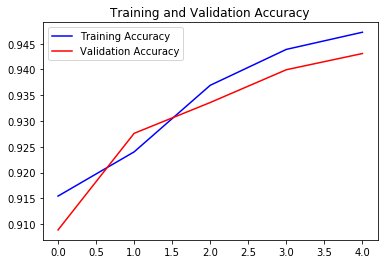

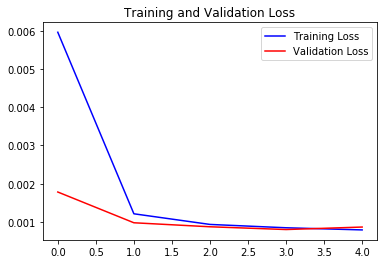

In [16]:
trained_model = train_model(autoencoder, neg_train, neg_train, neg_val, neg_val)  

# Calibrate the threshold

In [17]:
# function to calculate the mse for each image
# input: an array of images and array of corresponding reconstructions 
# returns: an array of mse values
def get_mse_array(original, reconstruction): 
    num_imgs = original.shape[0]
    mse_array = np.zeros(num_imgs)
    
    for i in range(num_imgs): 
        mse_array[i] = (np.square(original[i,:,:,:] - reconstruction[i,:,:,:])).mean()
    
    return mse_array

In [18]:
neg_val_reconstructions = trained_model.predict(neg_val)
pos_val_reconstructions = trained_model.predict(pos_val)

In [19]:
neg_val_mse = get_mse_array(neg_val, neg_val_reconstructions)
pos_val_mse = get_mse_array(pos_val, pos_val_reconstructions)

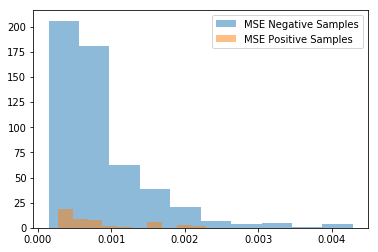

In [20]:
plt.hist(neg_val_mse, alpha=0.5, label='MSE Negative Samples')
plt.hist(pos_val_mse, alpha=0.5, label='MSE Positive Samples')
plt.legend(loc='upper right')
plt.show()

In [27]:
threshold = 0.001

# Test the model

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# This function comes from a scikit example found here: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

    np.set_printoptions(precision=2)

In [29]:
def classify(model, threshold, data):
    reconstruction = trained_model.predict(data) 
    mse_array = get_mse_array(data, reconstruction)
    predictions = np.zeros(mse_array.shape)
    for i in range(len(mse_array)):
        if mse_array[i] < threshold: 
            predictions[i] = 0 
        else: 
            predictions[i] = 1 
    return predictions

In [30]:
neg_pred = classify(trained_model, threshold, neg_test) 
pos_pred = classify(trained_model, threshold, pos_test) 

y_pred = np.concatenate((neg_pred, pos_pred))
y_true = np.concatenate((np.zeros(neg_pred.shape), np.ones(pos_pred.shape)))

Confusion matrix, without normalization
[[803 273]
 [ 21   1]]


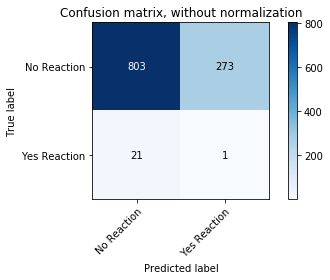

In [31]:
plot_confusion_matrix(y_true, y_pred, classes=['No Reaction', 'Yes Reaction']) 